# Setup DNN for Baarle-H problem

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader, TensorDataset
from typing import List

# Check for GPU availability
device = 'cpu'
print(f'Using device: {device}')

Using device: cpu


In [58]:
# Load Data
m = cv2.imread('data/Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:, :, (2, 1, 0)]

belgium_color = np.array([251, 234, 81])
netherlands_color = np.array([255, 255, 228])

netherlands_region = ((m - netherlands_color)**2).sum(-1) < 50
belgium_region = ((m - belgium_color)**2).sum(-1) < 10000

b_coords = np.array(np.where(belgium_region)).T.astype('float')
n_coords = np.array(np.where(netherlands_region)).T.astype('float')

# Flip and normalize coordinates to [-1, 1]
belgium_coords_all = np.zeros_like(b_coords)
netherlands_coords_all = np.zeros_like(n_coords)

belgium_coords_all[:, 0] = b_coords[:, 1] / (960 / 2) - 1
belgium_coords_all[:, 1] = (960 - b_coords[:, 0]) / (960 / 2) - 1
netherlands_coords_all[:, 0] = n_coords[:, 1] / (960 / 2) - 1
netherlands_coords_all[:, 1] = (960 - n_coords[:, 0]) / (960 / 2) - 1

np.random.seed(55)
num_points_to_sample = 10000
belgium_coords_sample = belgium_coords_all[np.random.choice(len(belgium_coords_all), 
                                                            num_points_to_sample), :]
netherlands_coords_sample=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), 
                                                                    num_points_to_sample), :]
X_sample = np.vstack((netherlands_coords_sample, belgium_coords_sample))
y_sample = np.concatenate((np.zeros(len(belgium_coords_sample)), 
                           np.ones(len(netherlands_coords_sample)))).astype('int')

rI=np.arange(len(y_sample))
np.random.shuffle(rI)
X_sample=X_sample[rI,:]
y_sample=y_sample[rI]

X_sample = torch.FloatTensor(X_sample)
y_sample = torch.tensor(y_sample)

In [5]:
X_sample.shape, y_sample.shape

(torch.Size([40000, 2]), torch.Size([40000]))

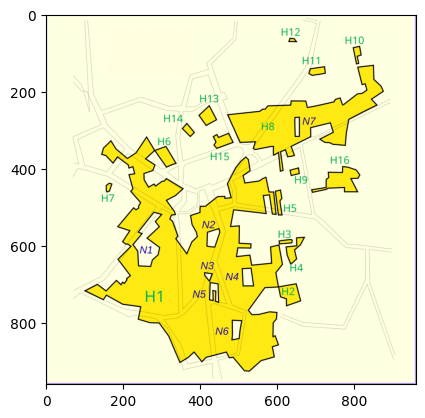

In [6]:
plt.imshow(m)

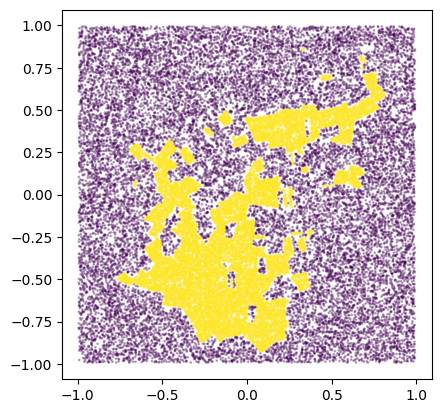

In [7]:
plt.scatter(X_sample[:,0], X_sample[:,1], c=y_sample, s=1, alpha=0.3); 
plt.axis('square');

In [34]:
# Network Arc
class MyNetwork(nn.Module):
    def __init__(self, layers: List[int] = [8]) -> None:
        super(MyNetwork, self).__init__()

        hidden_layers = []
        hidden_layers.append(nn.Linear(2, layers[0]))
        hidden_layers.append(nn.ReLU())

        for i in range(len(layers)-1):
            hidden_layers.append(nn.Linear(layers[i], layers[i+1]))
            hidden_layers.append(nn.ReLU())
        
        hidden_layers.append(nn.Linear(layers[-1], 2))

        self.layers = hidden_layers
        self.model = nn.Sequential(*hidden_layers)
    
    def forward(self, input):

        return self.model(input)

In [11]:
def viz_descision_boundary(model, res=256):
    plt.clf()
    fig = plt.figure(0, (6, 6))
    ax = fig.add_subplot(111)

    probe = np.zeros((res, res, 2))
    for j, xx in enumerate(np.linspace(-1, 1, res)):
        for k, yy in enumerate(np.linspace(-1, 1, res)):
            probe[j, k] = [yy, xx]
    probe = probe.reshape(res**2, -1)
    probe_logits = model(torch.tensor(probe).float().to(device))
    probe_logits = probe_logits.detach().cpu().numpy().reshape(res, res, 2)

    ax.imshow(m.mean(2), cmap='gray')
    ax.imshow(np.flipud(np.argmax(probe_logits, 2)),
               extent=[0, 960, 960, 0],
               alpha=0.7,
               cmap='viridis')

In [67]:
# Hyper params
num_epochs = 1000
lr = 0.01
layers = [32, 32, 32, 32]
torch.manual_seed(42)

/var/folders/hl/8lj29lfj7kd7g_ytn81j08b00000gn/T/ipykernel_92802/2949830910.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_out = model(torch.tensor(X_sample[index]).float())
/var/folders/hl/8lj29lfj7kd7g_ytn81j08b00000gn/T/ipykernel_92802/2949830910.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(model_out, torch.tensor(y_sample[index]))


Epoch [40/1000], Loss: 0.9624, Accuracy: 0.5954
Epoch [80/1000], Loss: 0.6303, Accuracy: 0.6387
Epoch [120/1000], Loss: 0.7190, Accuracy: 0.5674
Epoch [160/1000], Loss: 0.0180, Accuracy: 0.7298
Epoch [200/1000], Loss: 1.4682, Accuracy: 0.6335
Epoch [240/1000], Loss: 0.6146, Accuracy: 0.7120
Epoch [280/1000], Loss: 0.0072, Accuracy: 0.6150
Epoch [320/1000], Loss: 1.1143, Accuracy: 0.7634
Epoch [360/1000], Loss: 0.8294, Accuracy: 0.7296
Epoch [400/1000], Loss: 0.3376, Accuracy: 0.7137
Epoch [440/1000], Loss: 0.5074, Accuracy: 0.7579
Epoch [480/1000], Loss: 0.5429, Accuracy: 0.7902
Epoch [520/1000], Loss: 0.1949, Accuracy: 0.7279
Epoch [560/1000], Loss: 2.6501, Accuracy: 0.7278
Epoch [600/1000], Loss: 0.1973, Accuracy: 0.7100
Epoch [640/1000], Loss: 0.3012, Accuracy: 0.7262
Epoch [680/1000], Loss: 0.5948, Accuracy: 0.6974
Epoch [720/1000], Loss: 0.2506, Accuracy: 0.7183
Epoch [760/1000], Loss: 1.1018, Accuracy: 0.7416
Epoch [800/1000], Loss: 0.7257, Accuracy: 0.5000
Epoch [840/1000], Loss

<Figure size 640x480 with 0 Axes>

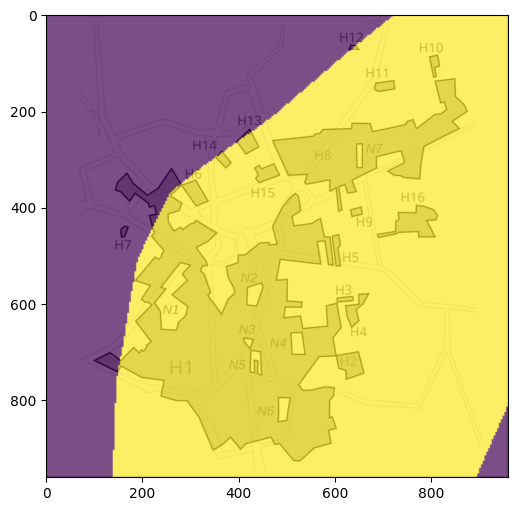

In [68]:
# training loop
model = MyNetwork(layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)

for i in range(num_epochs):

    optimizer.zero_grad()
    index = i%len(y_sample)
    
    model_out = model(torch.tensor(X_sample[index]).float())
    loss = criterion(model_out, torch.tensor(y_sample[index]))

    loss.backward()
    optimizer.step()

    if (i+1) % (num_epochs//25) == 0:

        out = model(X_sample)
        accuracy = (torch.argmax(out, dim=1)==y_sample).sum().item()/len(y_sample)
        print(f'Epoch [{i+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

viz_descision_boundary(model)


